In [24]:
# Basic Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Plot Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats


# **1.Load Data**

In [25]:
def func_xlsx_to_df(excel_file):
   
    # Read xlsx sheets and get the sheet names
    # Make sure column names are the same across all sheets in excel!!!
    xlsx = pd.ExcelFile(excel_file) 
    print(f"Excel filex '{excel_file}' contains {len(xlsx.sheet_names)} sheets: {xlsx.sheet_names}")

    # Turn xlsx sheet to df and contatenate all DFs to one df
    df = pd.DataFrame()
    for name in xlsx.sheet_names:
        #【Handling Missing Value】: "N.S." & "N/A" has corectly captured all the NaN valus across all columns.
        # However, 4th score has 0 as NaN thus no way to separate real NaN and 0 valus so treat all 0 as NaN.
        # But for 5th score 0 really means 0 score so has to keep!
        # Therefore, in this step we don't cound 0 as NaN in 'na_values' list, but process 4th score's 0 later.
        # Columns from 3 sheets appear 3 times so combined df has -3 rows
        sheet_to_df = pd.read_excel(excel_file, 
                                    sheet_name = name,
                                    na_values=["N.S.", "N/A", " "])
        sheet_to_df.insert(2,'Region',name)
        print(f"Reading sheet {name} into df with a shape:", sheet_to_df.shape)
        
        # Append new sheet as df into exsting df
        df = pd.concat([df, sheet_to_df], ignore_index=True, axis=0)
    
    return df
        
df = func_xlsx_to_df("CompanyListESG.xlsx")
print("The shape of the final df:", df.shape)

Excel filex 'CompanyListESG.xlsx' contains 3 sheets: ['NorthAmeric', 'APAC', 'Europe']
Reading sheet NorthAmeric into df with a shape: (3201, 12)
Reading sheet APAC into df with a shape: (2611, 12)
Reading sheet Europe into df with a shape: (2471, 12)
The shape of the final df: (8283, 12)


# **2.Data Processing & EDA**

In [26]:
def data_cleaning(df, build_classifier=False):
    # Use abbreviations to rename agency score names
    df = df.rename({"Cntry Terrtry Fl Name": "Country",
                    "GICS Sector": "Sector",
                    "GICS Ind Name": "Industry",
                    "GICS SubInd Name": "SubInd",
                    "Bloomberg Disclosure Score": "Scr_Blmbg", 
                    "MSCI ESG Rtg": "Scr_MSCI",
                    "ESG Score": "Scr_ESGS",
                    "Sustainalytics ESG Risk Score": "Scr_SERS",
                    "S&P RobecoSAM Tot Sustain Rnk": "Scr_S_P"
                    }, axis=1) 

    #【Handling Missing Value】: As mentioned above -- turn all 0 valus to NaN for 4th score
    df["Scr_SERS"] = df["Scr_SERS"].replace(0, np.nan)

    # Drop the only row which contain -1 for the 5th score - 只能run一次!!!
    df.drop(df[df["Scr_S_P"] == -1].index, inplace=True)
    
    # Give MCSI rating levels numerical representations
    MSCI_map = {"AAA":7, "AA":6, "A":5,"BBB":4, "BB":3, "B":2,"CCC":1}
    df["Scr_MSCI"] = df["Scr_MSCI"].replace(MSCI_map)
    
    
    return df

df = data_cleaning(df,build_classifier=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8282 entries, 0 to 8282
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     8281 non-null   object 
 1   Name       8282 non-null   object 
 2   Region     8282 non-null   object 
 3   Country    8281 non-null   object 
 4   Sector     8166 non-null   object 
 5   Industry   8166 non-null   object 
 6   SubInd     8166 non-null   object 
 7   Scr_Blmbg  2547 non-null   float64
 8   Scr_MSCI   2135 non-null   float64
 9   Scr_ESGS   956 non-null    float64
 10  Scr_SERS   2170 non-null   float64
 11  Scr_S_P    5985 non-null   float64
dtypes: float64(5), object(7)
memory usage: 841.1+ KB


In [27]:
# Check the number of NaN values in each column
df.isnull().sum()

Ticker          1
Name            0
Region          0
Country         1
Sector        116
Industry      116
SubInd        116
Scr_Blmbg    5735
Scr_MSCI     6147
Scr_ESGS     7326
Scr_SERS     6112
Scr_S_P      2297
dtype: int64

In [28]:
# Check unique values in important columns
display("----- Number of unique Countries:", len(df["Country"].unique()))
display("----- Number of unique values in each Region:", df["Region"].value_counts())
display("----- Number of unique values in each Sector:", df["Sector"].value_counts())
display("----- Number of unique Industries:", len(df["Industry"].unique()))

'----- Number of unique Countries:'

68

'----- Number of unique values in each Region:'

NorthAmeric    3200
APAC           2611
Europe         2471
Name: Region, dtype: int64

'----- Number of unique values in each Sector:'

Industrials               1361
Financials                1072
Information Technology     992
Consumer Discretionary     975
Health Care                873
Materials                  644
Real Estate                641
Consumer Staples           499
Communication Services     424
Energy                     374
Utilities                  311
Name: Sector, dtype: int64

'----- Number of unique Industries:'

70

In [29]:
# Check the distribution of each ESG score
display(df.describe())

,Scr_Blmbg,Scr_MSCI,Scr_ESGS,Scr_SERS,Scr_S_P
count,2547.000000,2135.000000,956.000000,2170.000000,5985.000000
mean,42.670173,4.554098,3.960157,23.382674,46.100752
std,13.480888,1.450124,1.346192,8.116823,27.337654
min,6.920800,1.000000,1.050000,5.438800,0.000000
25%,33.057800,4.000000,2.890000,17.345425,23.000000
50%,43.406100,5.000000,3.945000,22.426450,43.000000
75%,52.469600,6.000000,4.992500,28.229950,68.000000
max,78.804900,7.000000,7.530000,59.247300,100.000000


In [30]:
# Find the number of rows that have all 5 scores!!!
df[(~df["Scr_Blmbg"].isnull() 
    & ~df["Scr_MSCI"].isnull()
    & ~df["Scr_ESGS"].isnull()
    & ~df["Scr_SERS"].isnull()
    & ~df["Scr_S_P"].isnull())].count()

Ticker       193
Name         193
Region       193
Country      193
Sector       193
Industry     193
SubInd       193
Scr_Blmbg    193
Scr_MSCI     193
Scr_ESGS     193
Scr_SERS     193
Scr_S_P      193
dtype: int64

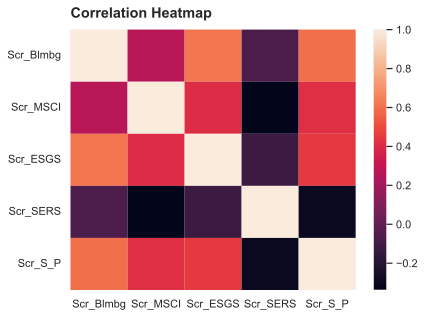

In [31]:
# cosmetic options
set_matplotlib_formats("svg")
rc = {"figure.figsize": (6.4, 4.8),
      "figure.dpi": 300,
      "axes.titlesize": "large",
      "axes.titleweight": "bold",
      "axes.titlepad": 12,
      "axes.titlelocation": "left"}
sns.set_theme(context="notebook", style="darkgrid", color_codes=True, rc=rc)

corr_heatmap = sns.heatmap(data=df.corr(method="pearson")).set_title("Correlation Heatmap")

In [32]:
df.head()

,Ticker,Name,Region,Country,Sector,Industry,SubInd,Scr_Blmbg,Scr_MSCI,Scr_ESGS,Scr_SERS,Scr_S_P
0,TER CN Equity,TERRASCEND CORP,NorthAmeric,Canada,Health Care,Pharmaceuticals,Pharmaceuticals,8.2645,NaN,NaN,NaN,NaN
1,CL CN Equity,CRESCO LABS INC-SUBORDINATE,NorthAmeric,United States,Health Care,Pharmaceuticals,Pharmaceuticals,9.5041,NaN,NaN,NaN,NaN
2,FMBL US Equity,FARMERS & MERCHANTS BANK/CA,NorthAmeric,United States,Financials,Banks,Regional Banks,10.9649,NaN,NaN,NaN,NaN
3,LIND US Equity,LINDBLAD EXPEDITIONS HOLDING,NorthAmeric,United States,Consumer Discretionary,"Hotels, Restaurants & Leisure","Hotels, Resorts & Cruise Lines",12.3967,NaN,NaN,NaN,NaN
4,UI US Equity,UBIQUITI INC,NorthAmeric,United States,Information Technology,Communications Equipment,Communications Equipment,12.8099,NaN,NaN,NaN,31.0


# **3.Modeling**

In [33]:
def data_process(df, col_to_drop, ft_to_ohe, build_classifier=False):
    # Drop useless features
    df = df.drop(col_to_drop, axis=1)
    
    # If wanna build a classifier based on MSCI classes, then run theblock:
    if build_classifier:
        # Hard labeling MCSI rating levels into 1/0 classes
        MSCI_map = {7.0:1, 6.0:1, 5.0:1, 4.0:0, 3.0:0, 2.0:0, 1.0:0}
        df["Scr_MSCI"] = df["Scr_MSCI"].replace(MSCI_map)
        df = df.dropna(subset=["Scr_MSCI"])
        # display(df["Scr_MSCI"].value_counts(), df["Scr_MSCI"].sum())  ### Sanity check
    
    # One-Hot-Encode categorical features, need  
    for feature in ft_to_ohe:
        ohe= OneHotEncoder(handle_unknown='ignore')
        ohe_df = pd.DataFrame(ohe.fit_transform(df[[feature]]).toarray())
        df = df.join(ohe_df, how='left', lsuffix='left', rsuffix='right')
        df.drop(columns=[feature], inplace=True)
    
    # Normalization of the scores
    
    return df


col_to_drop = ["Ticker", "Name", "Country", "Industry", "SubInd"]
ft_to_ohe = ["Region", "Sector"]
df2 = data_process(df, 
                   col_to_drop=col_to_drop,
                   build_classifier=True,
                   ft_to_ohe = ft_to_ohe)
df2.head()

,Scr_Blmbg,Scr_MSCI,Scr_ESGS,Scr_SERS,Scr_S_P,0left,1left,2left,0right,1right,2right,3,4,5,6,7,8,9,10
61,18.1818,0.0,NaN,28.4424,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
77,19.4215,1.0,NaN,17.6910,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
102,23.1405,0.0,NaN,16.7001,21.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,26.9490,1.0,NaN,22.9152,12.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,29.3388,1.0,NaN,19.5513,76.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Sanity check of the results of One-Hot-Encoding:
# display(df["Region"].value_counts())
# display(df["Sector"].value_counts())
# print(df2[3].sum(), df2[4].sum(), df2["0right"].sum())

In [34]:
df2.shape

(2135, 19)

In [38]:
# Putting feature variables to X
X = df2.drop("Scr_MSCI",axis=1)
# Putting response variable to y
y = df2["Scr_MSCI"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((1494, 18), (641, 18))

In [ ]:

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)
classifier_rf.fit(X_train, y_train)
y_pred_test = classifier_rf.predict(X_test)
accuracy_score(y_test, y_pred_test)